In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR

from skopt.searchcv import BayesSearchCV
from skopt.space import Categorical, Real, Integer

In [2]:
class feature_filter(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        assert type(columns) == list
        self.columns = columns

    def fit(self, X, y=None):
        # No fit functionality
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns)

In [3]:
class efficiency_feature(BaseEstimator, TransformerMixin):
    
    def __init__(self, polytropicCompression, temperature="C"):
        self.polytropicCompression = polytropicCompression
        self.temperature = temperature

        if temperature == "C":
            self.temperatureCorrection = 273.15
        else:
            self.temperatureCorrection = 0

    def fit(self, X, y=None):
        # No fit functionality
        return self

    def transform(self, X, y=None):
        CAT = np.array([])
        BCE = np.array([])
        pressure_ratio = X["CDP"] / (X["AP"] / 1000)
        CAT = ((X["AT"] + 273.15) * np.power(pressure_ratio, 0.32)) - 273.15
        efficiency_num = (X["AT"] + 273.15) * ((X["TAT"] + 273.15)/(X["AT"] + 273.15) - 1)
        efficiency_denom = (CAT + 273.15) * ((X["TIT"] + 273.15)/(CAT + 273.15) - 1)
        BCE = 1 - efficiency_num / efficiency_denom
        BCE = pd.Series(BCE, name="BCE", dtype="float64")
        return pd.concat((X, BCE), axis=1)

In [4]:
def evaluator(model_list, fold_of_cv):
    cv_results = pd.DataFrame(index=["Split_{:d}_Test_Score".format(i) for i in range(0, fold_of_cv)])
    coef_of_determination_test = pd.Series(dtype=np.float64)
    MSE_scores_test = pd.Series(dtype=np.float64)

    column_range_for_cv_cols = -3 - fold_of_cv

    for model in tqdm(model_list.keys()):
        temp_df = pd.DataFrame(model_list[model].cv_results_).sort_values(by="rank_test_score")
        cv_results[model] = np.sqrt(np.abs(temp_df.iloc[0, column_range_for_cv_cols:-3].values).astype(np.float64))
        
        coef_of_determination_test[model] = model_list[model].best_estimator_.score(X_test, y_test)
        y_pred = model_list[model].best_estimator_.predict(X_test)
        MSE_scores_test[model] = np.sqrt(MSE(y_test, y_pred))


    for model in coef_of_determination_test.index.values:
        print("Test Results:")
        print("{:s} için elde edilen R^2 değeri: {:.4f}".format(model, coef_of_determination_test[model]))
        print("{:s} için elde edilen RMSE değeri: {:.4f}".format(model, MSE_scores_test[model]))
        print("\n" + "*"*50 + "\n")


    ax = sns.boxplot(data=cv_results.melt(), y="variable", x="value")
    ax.set_xlabel("RMSE Ölçütü (ppm)")
    ax.set_ylabel("Model Adı")
    plt.show()
    
    cv_results.loc["Mean", :] = cv_results.mean()
    cv_results.loc["Std", :] = cv_results.std()
    display(cv_results)
    return cv_results

In [5]:
def model_random_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_spline=False, use_efficiency=False, use_filter=False, polytropic_compression=0.28, filter_columns=None, metric="neg_mean_squared_error"):
    # Random Forest Random Search
    random_forest_pipeline = Pipeline(steps=[
        ("random_forest", RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state=random_state))
    ])

    if use_spline:
        random_forest_pipeline.steps.insert(0, ("spline", SplineTransformer()))

    if use_filter:
        random_forest_pipeline.steps.insert(0, ("filter", feature_filter(filter_columns)))

    if use_efficiency:
        random_forest_pipeline.steps.insert(0, ("eff_addition", efficiency_feature(polytropic_compression)))

    param_distributions = {
        "random_forest__n_estimators": np.linspace(5, 350, 7).astype(np.int32),
        "random_forest__max_depth": np.linspace(5, 50, 7).astype(np.int32),
        "random_forest__max_features": np.linspace(0.1, 1, 7),
        "random_forest__min_samples_leaf": np.linspace(1, 20, 5).astype(np.int32)
    }

    random_search_random_forest = RandomizedSearchCV(random_forest_pipeline, param_distributions=param_distributions, scoring=metric, cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
    random_search_random_forest.fit(X_train, y_train)
    display("Random Forest end.")



    # Adaboost Random Search
    adaboost_pipeline = Pipeline(steps=[
    ("adaboost", AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state), random_state=random_state))
    ])

    if use_spline:
        adaboost_pipeline.steps.insert(0, ("spline", SplineTransformer()))

    if use_filter:
        adaboost_pipeline.steps.insert(0, ("filter", feature_filter(filter_columns)))

    if use_efficiency:
        adaboost_pipeline.steps.insert(0, ("eff_addition", efficiency_feature(polytropic_compression)))

    param_distributions = {
        "adaboost__base_estimator__max_depth": np.linspace(1, 10, 5).astype(np.int32),
        "adaboost__base_estimator__min_samples_leaf": np.linspace(1, 10, 5).astype(np.int32),
        "adaboost__base_estimator__splitter": ["best", "random"],
        "adaboost__n_estimators": np.linspace(5, 300, 5).astype(np.int32),
        "adaboost__loss": ["linear", "square"]
    }

    random_search_adaboost = RandomizedSearchCV(adaboost_pipeline, param_distributions=param_distributions, scoring=metric, cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
    random_search_adaboost.fit(X_train, y_train)
    display("Adaboost end.")
    


    # Histogram Gradient Random Search
    hist_grad_pipeline = Pipeline(steps=[
    ("hist_grad", HistGradientBoostingRegressor())
    ])

    if use_spline:
        hist_grad_pipeline.steps.insert(0, ("spline", SplineTransformer()))

    if use_filter:
        hist_grad_pipeline.steps.insert(0, ("filter", feature_filter(filter_columns)))

    if use_efficiency:
        hist_grad_pipeline.steps.insert(0, ("eff_addition", efficiency_feature(polytropic_compression)))

    param_distributions = {
        "hist_grad__max_iter": np.logspace(2, 4, 3).astype(np.int32),
        "hist_grad__l2_regularization": np.logspace(-1, 3, 5),
        "hist_grad__learning_rate": np.logspace(-3, 2, 6),
        "hist_grad__max_bins": np.logspace(4, 7, 4, base=2).astype(np.int32)
    }

    random_search_hist_grad = RandomizedSearchCV(hist_grad_pipeline, param_distributions=param_distributions, scoring=metric, cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
    random_search_hist_grad.fit(X_train, y_train)
    display("Histogram Gradient end.")
    return random_search_random_forest, random_search_adaboost, random_search_hist_grad


In [6]:
def permutation_test_independent(firstSampling, secondSampling, alternative="less"):
    # firstSampling: pd.Series
    # secondSampling: pd.Series
    # Label: string
    # hypothesis: less or greater means first sampling is lesser or greater than second sampling

    numberofPerm = 10000
    firstSamplingLength = len(firstSampling)
    secondSamplingLength = len(secondSampling)
    samplingPool = np.concatenate((firstSampling.values.reshape(-1, 1), secondSampling.values.reshape(-1, 1)), axis=0).ravel()
    labelPool = ["firstLabel" for i in range(firstSamplingLength)]
    labelPool.extend(["secondLabel"] * secondSamplingLength)
    labelPool = np.array(labelPool).ravel()
    
    if alternative == "less":
        observedDifference = np.median(secondSampling) - np.median(firstSampling)
    elif alternative == "greater":
        observedDifference = np.median(firstSampling) - np.median(secondSampling)
    else:
        raise ValueError
    
    permutations = []
    extremePermutations = []

    for i in range(numberofPerm):
        sampledData = np.random.choice(samplingPool, size=(firstSamplingLength + secondSamplingLength), replace=False)
        sampledLabel = np.random.choice(labelPool, size=(firstSamplingLength + secondSamplingLength), replace=False)

        firstSamplingFilter = np.argwhere(sampledLabel == "firstLabel")
        secondSamplingFilter = np.argwhere(sampledLabel == "secondLabel")

        if alternative == "less":
            permutatedDifference = np.median(sampledData[secondSamplingFilter]) - np.median(sampledData[firstSamplingFilter])
        elif alternative == "greater":
            permutatedDifference = np.median(sampledData[firstSamplingFilter]) - np.median(sampledData[secondSamplingFilter])

        extremePermutations.append(permutatedDifference > observedDifference)
        permutations.append(permutatedDifference)

    # ax = sns.histplot(x=permutations)
    # ax.vlines(observedDifference, ymin=0, ymax=1500, color="red")
    # plt.show()
    
    return np.mean(extremePermutations)


In [7]:
#!ls /datasets/personal-gd/Tunahan/Master/VBM/VBM683/Data\ Set

df_2011 = pd.read_csv("Data Set/gt_2011.csv")
df_2012 = pd.read_csv("Data Set/gt_2012.csv")
df_2013 = pd.read_csv("Data Set/gt_2013.csv")
df_2014 = pd.read_csv("Data Set/gt_2014.csv")
df_2015 = pd.read_csv("Data Set/gt_2015.csv")

df = pd.concat([df_2011, df_2012, df_2013, df_2014, df_2015])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36733 entries, 0 to 7383
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.4 MB


**Features**
<ul>
<li>AT: Ambient Temperature, C</li>
<li>AP: Ambient Pressure, mbar</li>
<li>AH: Ambient Humidity, %</li>
<li>AFDP: Air Filter Difference Pressure, mbar</li>
<li>GTEP: Gas Turbine Exhaust Pressure, mbar</li>
<li>TIT: Turbine Inlet Temperature, C</li>
<li>TAT: Turbine After Temperature, C</li>
<li>CDP: Compressor Discharge Pressure, bar</li>
<li>TEY: Turbine Energy Yield, MWH</li>
</ul>

**Target**
<ul>
<li>CO: Carbon Monoxide, mg/m3 || ppm</li>
<li>NOx: Nitrogen Oxides, mg/m3 || ppm</li>
</ul>

In [9]:
display(df.shape)
display(df.describe())

(36733, 11)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000
mean,17.712726,1013.070165,77.867015,3.925518,25.563801,1081.428084,546.158517,133.506404,12.060525,2.372468,65.293067
std,7.447451,6.463346,14.461355,0.773936,4.195957,17.536373,6.842360,15.618634,1.088795,2.262672,11.678357
min,-6.234800,985.850000,24.085000,2.087400,17.698000,1000.800000,511.040000,100.020000,9.851800,0.000388,25.905000
25%,11.781000,1008.800000,68.188000,3.355600,23.129000,1071.800000,544.720000,124.450000,11.435000,1.182400,57.162000
50%,17.801000,1012.600000,80.470000,3.937700,25.104000,1085.900000,549.880000,133.730000,11.965000,1.713500,63.849000
75%,23.665000,1017.000000,89.376000,4.376900,29.061000,1097.000000,550.040000,144.080000,12.855000,2.842900,71.548000
max,37.103000,1036.600000,100.200000,7.610600,40.716000,1100.900000,550.610000,179.500000,15.159000,44.103000,119.910000


100%|██████████| 11/11 [00:01<00:00,  9.41it/s]


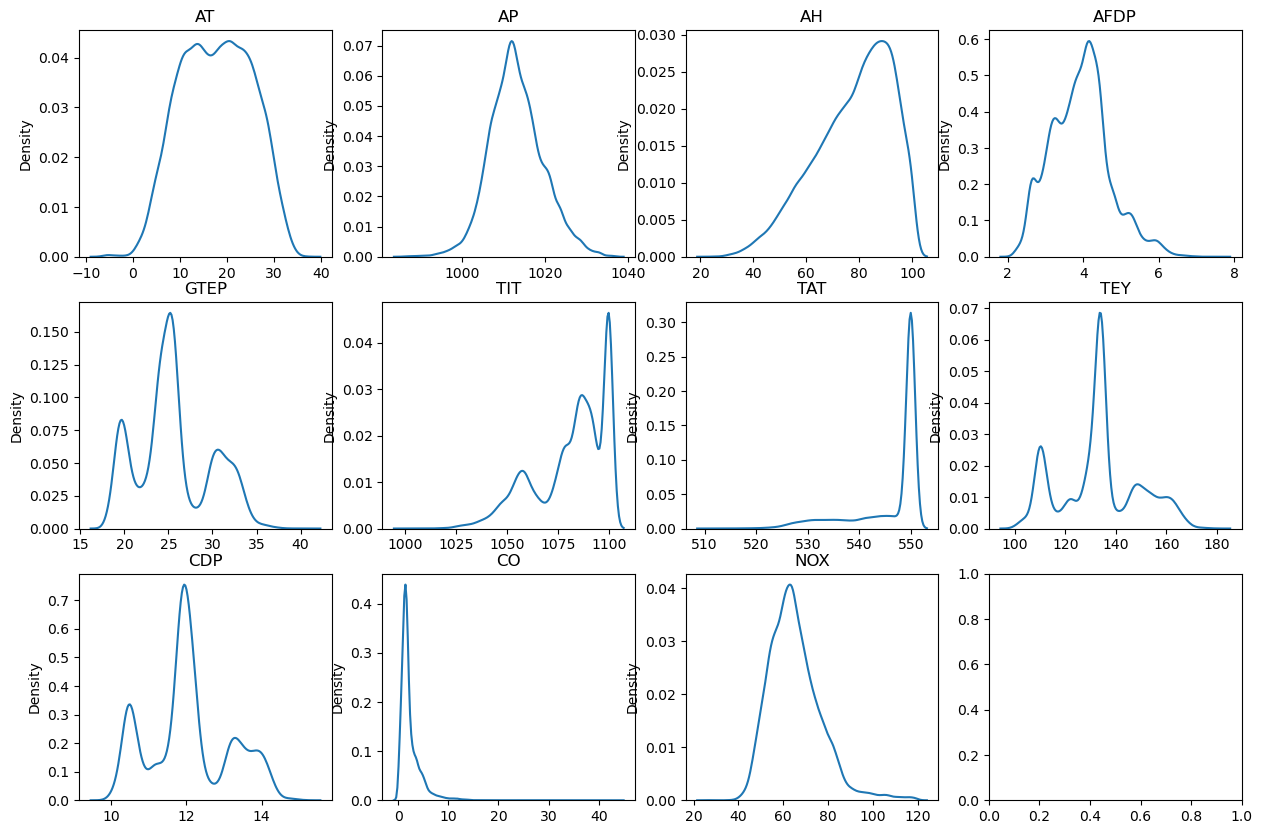

In [10]:
#Her niteliğin dağılımını incele
fig, axes = plt.subplots(ncols=4, nrows=3, sharex=False, sharey=False)

column_list = df.columns.values
for column, ax in zip(tqdm(column_list), np.ravel(axes)):
    sns.kdeplot(data=df, x=column, ax=ax)
    ax.set_xlabel("")
    ax.set_title(column)

fig.set_size_inches(15, 10)

In [11]:
# import statsmodels.api as sm

# df["Transformed_NOX"] = np.log(df["NOX"])

# fig, ax = plt.subplots(nrows=2, ncols=2)
# sns.histplot(data=df, x="NOX", ax=ax[0][0])
# sns.histplot(data=df, x="Transformed_NOX", ax=ax[0][1])
# sm.qqplot(df["NOX"], line = "45", fit = True, ax=ax[1][0])
# sm.qqplot(df["Transformed_NOX"], line = "45", fit = True, ax=ax[1][1])
# fig.set_size_inches(10,8)

100%|██████████| 11/11 [00:10<00:00,  1.03it/s]


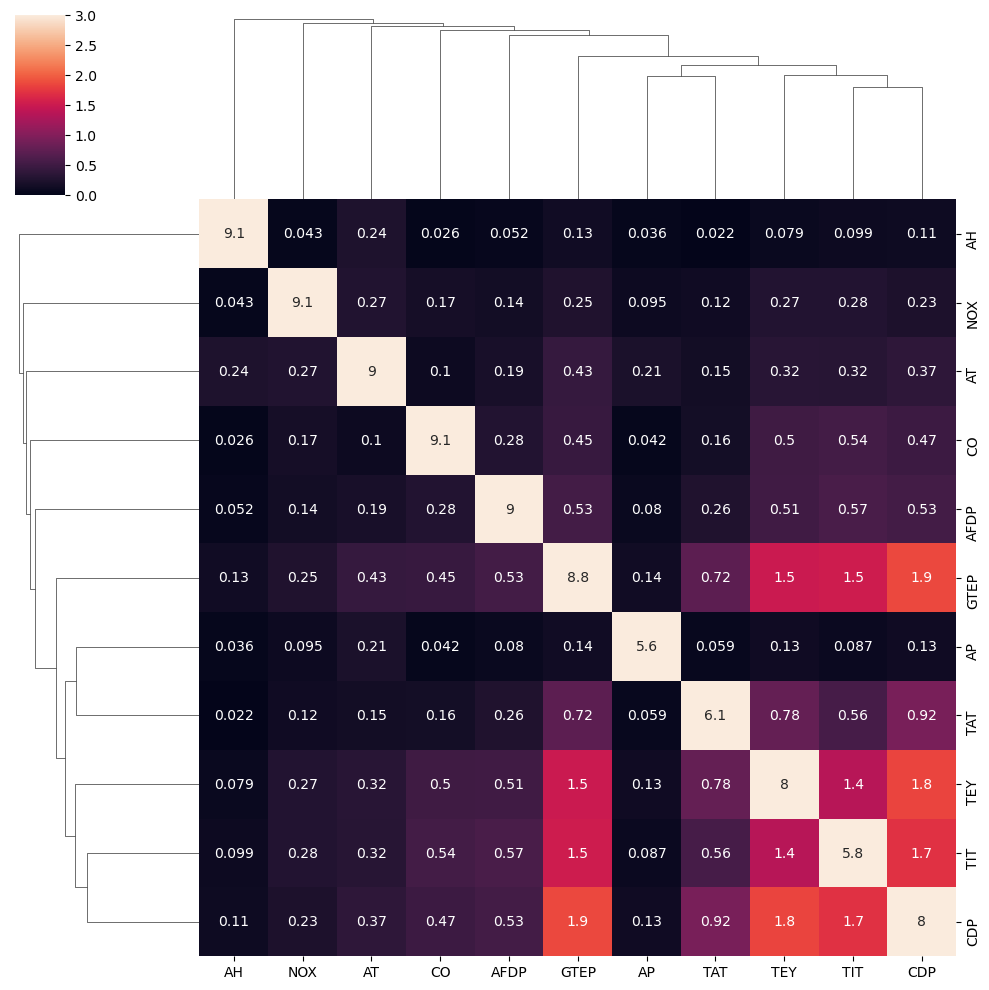

In [12]:
number_of_features = len(df.columns)
correlation_matrix = np.ones((number_of_features, number_of_features))

#Doğrusal ve doğrusal olmayan ilişkileri görmek için mutual_info skorelarını hiyerarşik olarak incele
for row in tqdm(range(number_of_features)):
    for col in range(number_of_features):
        if col > row: #Korelasyon matrisi simetrik olduğu için işlem sadece alt üçgen matris için yapıldı
            continue
        correlation_matrix[row][col] = mutual_info_regression(df.iloc[:, row].values.reshape(-1, 1), df.iloc[:, col].values.ravel())

#Alt üçgen matrisi üst üçgen matrise yapıştır
for row in range(number_of_features):
    for col in range(number_of_features):
        if col < row:
            continue
        correlation_matrix[row][col] = correlation_matrix[col][row]

correlation_df = pd.DataFrame(correlation_matrix, columns=df.columns, index=df.columns)
sns.clustermap(correlation_df, annot=True, vmin=0, vmax=3)

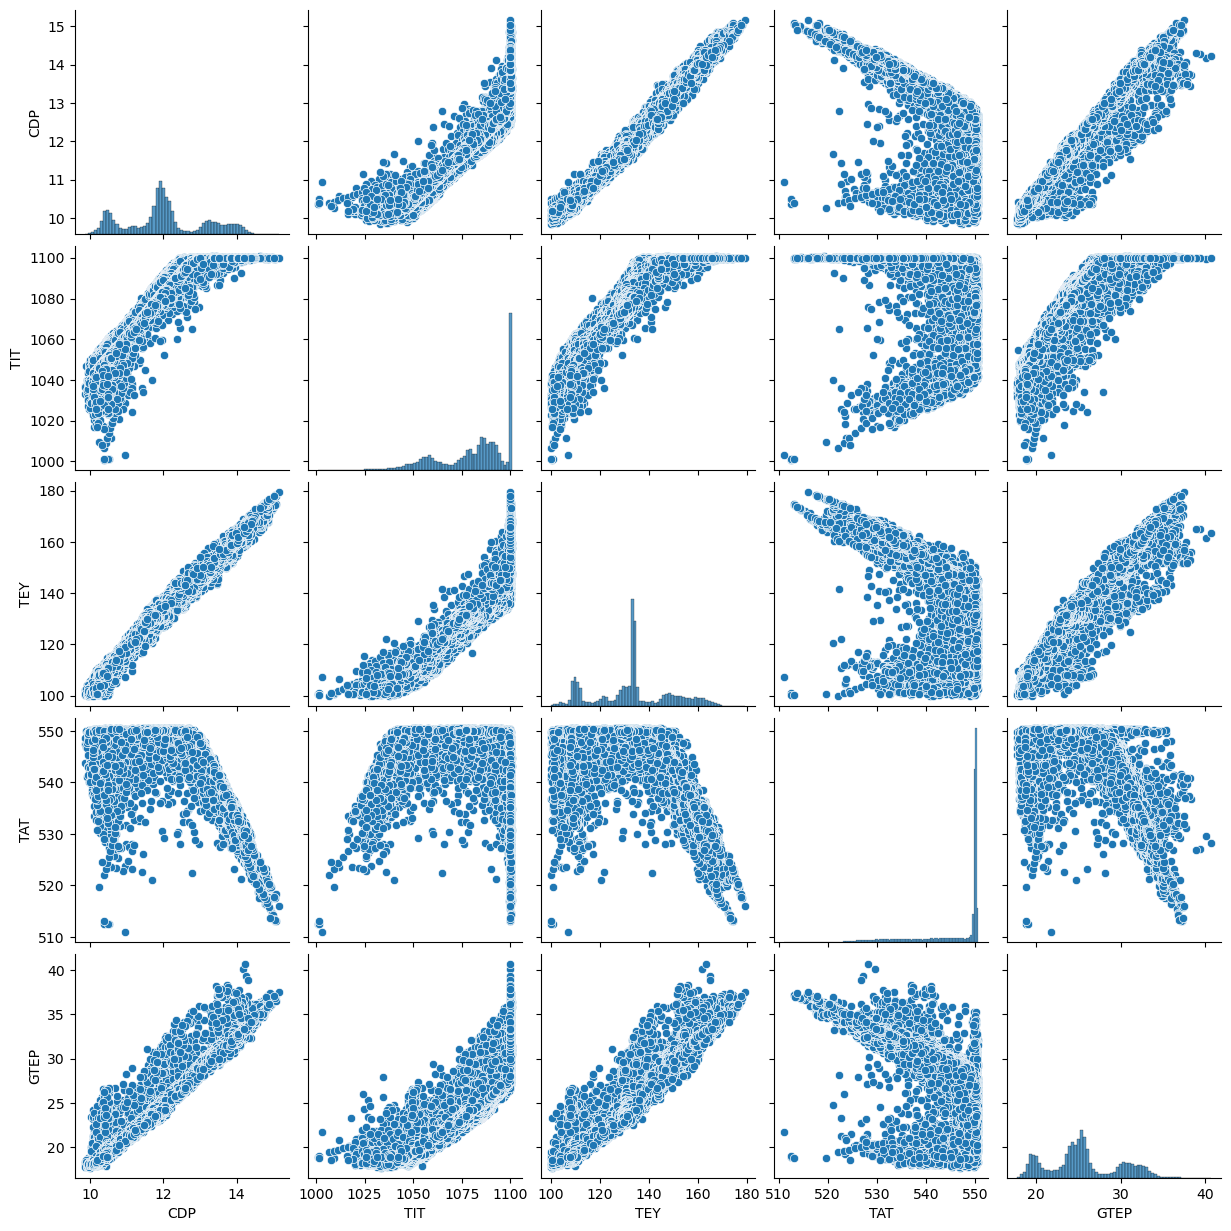

In [13]:
#Mutual_info grafiğinde yer alan kümeleşmeler veriler arasında manalı bir ilişki olabileceğini gösterdi.
#Dolayısıyla pairplot ile ilişkileri görselleştirebiliriz.

selected_features = ["CDP", "TIT", "TEY", "TAT", "GTEP"]
sns.pairplot(data=df[selected_features])

In [14]:
targets = ["NOX", "CO"]
feature_list = np.setdiff1d(column_list, targets)
display(column_list)
display(feature_list)
display(df.loc[:, targets[1]].describe())

X = df.loc[:, feature_list]
y = df.loc[:, targets[1]]
random_state = 2022

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state)

array(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'], dtype=object)

array(['AFDP', 'AH', 'AP', 'AT', 'CDP', 'GTEP', 'TAT', 'TEY', 'TIT'],
      dtype=object)

count    36733.000000
mean         2.372468
std          2.262672
min          0.000388
25%          1.182400
50%          1.713500
75%          2.842900
max         44.103000
Name: CO, dtype: float64

In [15]:
%store -r rfMSE
%store -r adaboostMSE
%store -r histgradMSE
%store -r featureEngRF_CO
%store -r featureEngAdaboost_CO
%store -r featureEngHistGrad_CO
%store -r splineRF_CO
%store -r splineAdaboost_CO
%store -r splineHistGrad_CO
%store -r importance_analysis_CO
%store -r filterRF_CO
%store -r filterAdaboost_CO
%store -r filterHistGrad_CO
%store -r bayes_search_random_forest_CO

# Model Type Selection

In [16]:
n_iter = 75 #Iteration count for random search trails
fold_of_cv = 7

In [ ]:
rfMSE, adaboostMSE, histgradMSE = model_random_searcher(X_train, y_train, fold_of_cv, n_iter, random_state)

%store rfMSE
%store adaboostMSE
%store histgradMSE

100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Test Results:
Random Forest için elde edilen R^2 değeri: 0.7828
Random Forest için elde edilen RMSE değeri: 1.0174

**************************************************

Test Results:
Adaboost için elde edilen R^2 değeri: 0.7221
Adaboost için elde edilen RMSE değeri: 1.1509

**************************************************

Test Results:
Histogram Gradient Boosting için elde edilen R^2 değeri: 0.7450
Histogram Gradient Boosting için elde edilen RMSE değeri: 1.1024

**************************************************



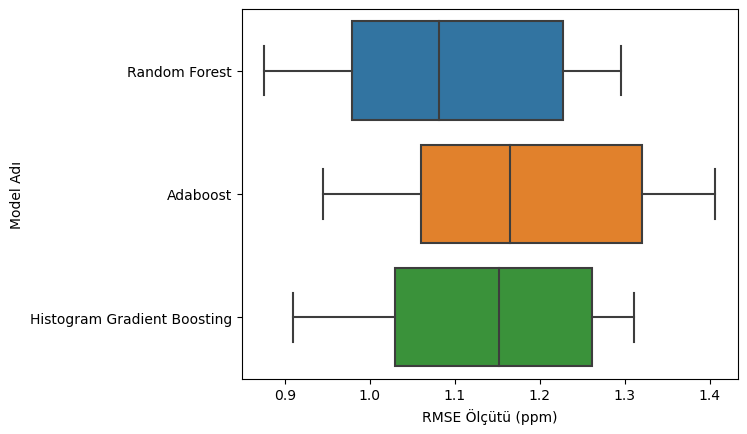

,Random Forest,Adaboost,Histogram Gradient Boosting
Split_0_Test_Score,1.295506,1.397139,1.275694
Split_1_Test_Score,0.875714,0.945620,0.910241
Split_2_Test_Score,0.927301,1.023801,1.018227
Split_3_Test_Score,1.032007,1.098136,1.040952
Split_4_Test_Score,1.162219,1.244895,1.247415
Split_5_Test_Score,1.293400,1.406357,1.310799
Split_6_Test_Score,1.082140,1.164679,1.151816
Mean,1.095470,1.182947,1.136449
Std,0.153262,0.164232,0.139695


In [27]:
model_list = {
    "Random Forest": rfMSE,
    "Adaboost": adaboostMSE,
    "Histogram Gradient Boosting": histgradMSE
}

cv_results_model_eval = evaluator(model_list, fold_of_cv)

In [29]:
random_forest_results = pd.DataFrame([cv_results_model_eval.drop(labels=["Mean", "Std"], axis=0)["Random Forest"], cv_results_model_eval.drop(labels=["Mean", "Std"], axis=0)["Histogram Gradient Boosting"]]).T
p_value = permutation_test_independent(random_forest_results["Random Forest"], random_forest_results["Histogram Gradient Boosting"], alternative="less")
display("Random Forest results are {} than Histogram Gradient Boosting. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Random Forest results are NOT better than Histogram Gradient Boosting. P-value is 0.388'

# Feature Engineering

100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


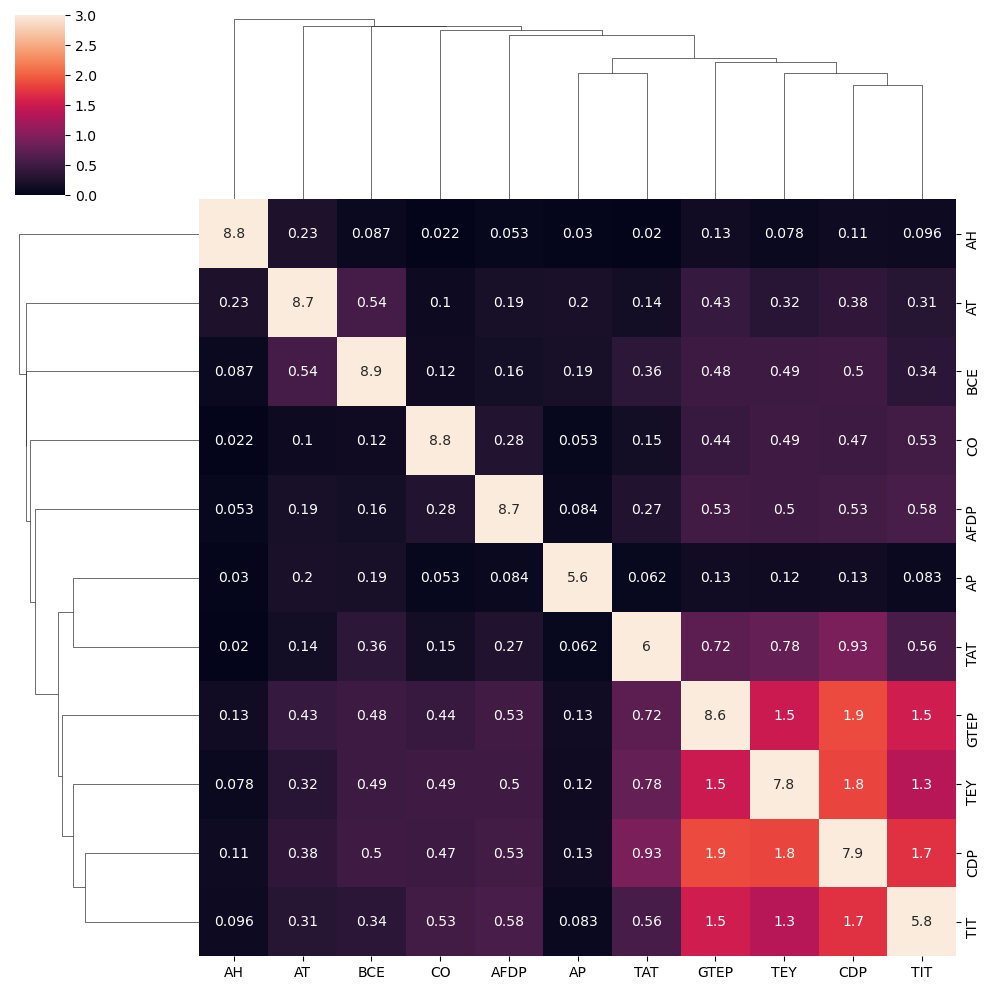

In [30]:
feature_adder = efficiency_feature(0.32)
df = pd.concat((feature_adder.fit_transform(X_train), y_train), axis=1)

number_of_features = len(df.columns)
correlation_matrix = np.ones((number_of_features, number_of_features))

#Doğrusal ve doğrusal olmayan ilişkileri görmek için mutual_info skorelarını hiyerarşik olarak incele
for row in tqdm(range(number_of_features)):
    for col in range(number_of_features):
        if col > row: #Korelasyon matrisi simetrik olduğu için işlem sadece alt üçgen matris için yapıldı
            continue
        correlation_matrix[row][col] = mutual_info_regression(df.iloc[:, row].values.reshape(-1, 1), df.iloc[:, col].values.ravel())

#Alt üçgen matrisi üst üçgen matrise yapıştır
for row in range(number_of_features):
    for col in range(number_of_features):
        if col < row:
            continue
        correlation_matrix[row][col] = correlation_matrix[col][row]

correlation_df = pd.DataFrame(correlation_matrix, columns=df.columns, index=df.columns)
sns.clustermap(correlation_df, annot=True, vmin=0, vmax=3)

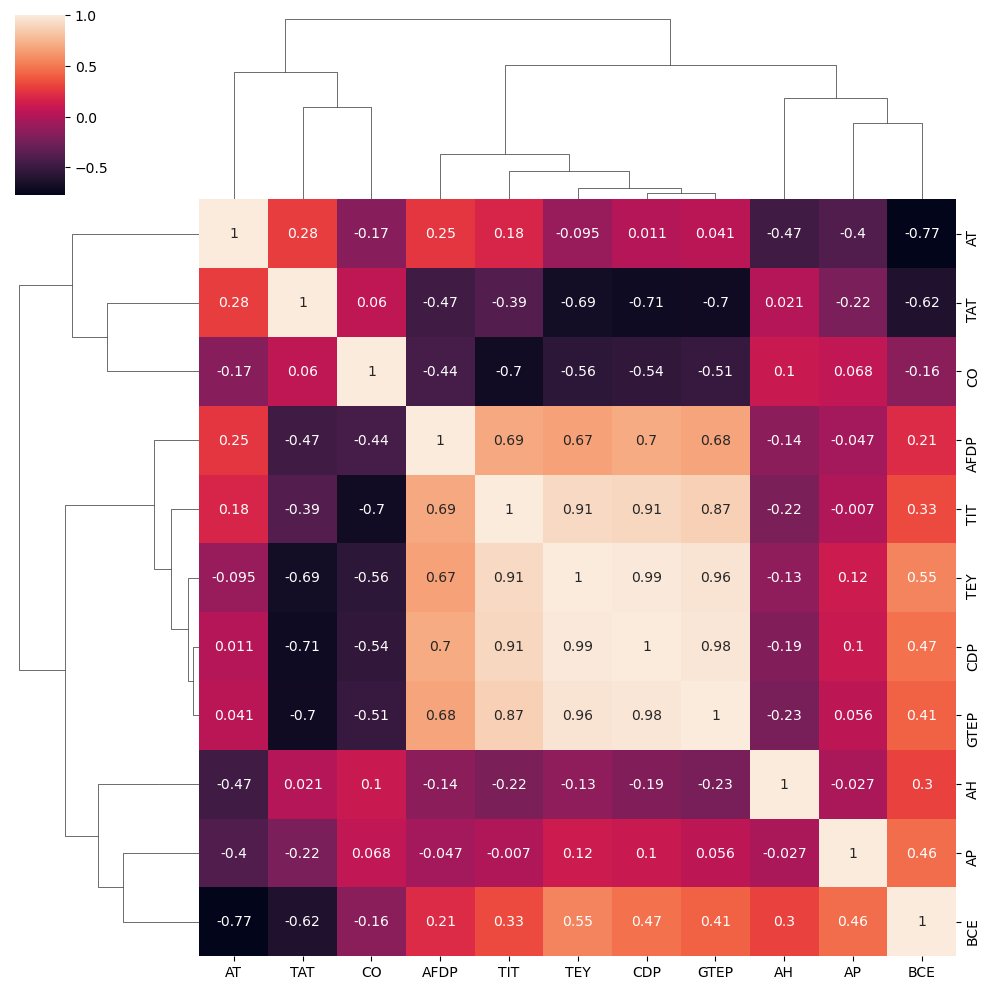

In [31]:
sns.clustermap(df.corr(), annot=True)

In [ ]:
featureEngRF_CO, featureEngAdaboost_CO, featureEngHistGrad_CO = model_random_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_efficiency=True, polytropic_compression=0.32)

%store featureEngRF_CO
%store featureEngAdaboost_CO
%store featureEngHistGrad_CO

100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Test Results:
Random_Forest için elde edilen R^2 değeri: 0.7828
Random_Forest için elde edilen RMSE değeri: 1.0174

**************************************************

Test Results:
Adaboost için elde edilen R^2 değeri: 0.7221
Adaboost için elde edilen RMSE değeri: 1.1509

**************************************************

Test Results:
Hist_Grad için elde edilen R^2 değeri: 0.7450
Hist_Grad için elde edilen RMSE değeri: 1.1024

**************************************************

Test Results:
Random_Forest_Feature_Eng için elde edilen R^2 değeri: 0.7845
Random_Forest_Feature_Eng için elde edilen RMSE değeri: 1.0136

**************************************************

Test Results:
Adaboost_Feature_Eng için elde edilen R^2 değeri: 0.7407
Adaboost_Feature_Eng için elde edilen RMSE değeri: 1.1117

**************************************************

Test Results:
Hist_Grad_Feature_Eng için elde edilen R^2 değeri: 0.7587
Hist_Grad_Feature_Eng için elde edilen RMSE değeri: 1.0724

********

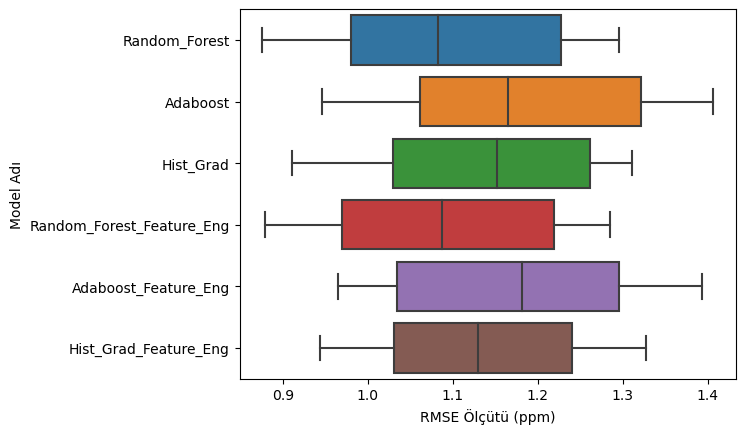

,Random_Forest,Adaboost,Hist_Grad,Random_Forest_Feature_Eng,Adaboost_Feature_Eng,Hist_Grad_Feature_Eng
Split_0_Test_Score,1.295506,1.397139,1.275694,1.276787,1.335836,1.283303
Split_1_Test_Score,0.875714,0.945620,0.910241,0.879314,0.965012,0.944286
Split_2_Test_Score,0.927301,1.023801,1.018227,0.918406,0.996037,1.003011
Split_3_Test_Score,1.032007,1.098136,1.040952,1.021877,1.072201,1.058829
Split_4_Test_Score,1.162219,1.244895,1.247415,1.161861,1.254547,1.198042
Split_5_Test_Score,1.293400,1.406357,1.310799,1.284867,1.393420,1.326934
Split_6_Test_Score,1.082140,1.164679,1.151816,1.087294,1.180873,1.129651
Mean,1.095470,1.182947,1.136449,1.090058,1.171132,1.134865
Std,0.153262,0.164232,0.139695,0.149527,0.154237,0.132250


In [32]:
model_list = {
    "Random_Forest": rfMSE,
    "Adaboost": adaboostMSE,
    "Hist_Grad": histgradMSE,
    "Random_Forest_Feature_Eng": featureEngRF_CO,
    "Adaboost_Feature_Eng": featureEngAdaboost_CO,
    "Hist_Grad_Feature_Eng": featureEngHistGrad_CO
}

cv_results_efficiency = evaluator(model_list, fold_of_cv)

In [33]:
random_forest_results = pd.DataFrame([cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random_Forest"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random_Forest_Feature_Eng"]]).T
p_value = permutation_test_independent(random_forest_results["Random_Forest_Feature_Eng"], random_forest_results["Random_Forest"], alternative="less")
display("Feature engineered results are {} than original dataset. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Feature engineered results are NOT better than original dataset. P-value is 0.497'

In [34]:
adaboost_results = pd.DataFrame([cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost_Feature_Eng"]]).T
p_value = permutation_test_independent(adaboost_results["Adaboost_Feature_Eng"], adaboost_results["Adaboost"], alternative="less")
display("Feature engineered results are {} than original dataset. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Feature engineered results are NOT better than original dataset. P-value is 0.502'

In [35]:
hist_grad_results = pd.DataFrame([cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Hist_Grad"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Hist_Grad_Feature_Eng"]]).T
p_value = permutation_test_independent(hist_grad_results["Hist_Grad_Feature_Eng"], hist_grad_results["Hist_Grad"], alternative="less")
display("Feature engineered results are {} than original dataset. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Feature engineered results are NOT better than original dataset. P-value is 0.386'

## Spline Features

In [ ]:
splineRF_CO, splineAdaboost_CO, splineHistGrad_CO = model_random_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_efficiency=True, use_spline=True, polytropic_compression=0.32)

%store splineRF_CO
%store splineAdaboost_CO
%store splineHistGrad_CO

100%|██████████| 9/9 [00:02<00:00,  3.37it/s]


Test Results:
Random Forest için elde edilen R^2 değeri: 0.7828
Random Forest için elde edilen RMSE değeri: 1.0174

**************************************************

Test Results:
Adaboost için elde edilen R^2 değeri: 0.7221
Adaboost için elde edilen RMSE değeri: 1.1509

**************************************************

Test Results:
Histogram Gradient Boosting için elde edilen R^2 değeri: 0.7450
Histogram Gradient Boosting için elde edilen RMSE değeri: 1.1024

**************************************************

Test Results:
Random Forest BCE için elde edilen R^2 değeri: 0.7845
Random Forest BCE için elde edilen RMSE değeri: 1.0136

**************************************************

Test Results:
Adaboost BCE için elde edilen R^2 değeri: 0.7407
Adaboost BCE için elde edilen RMSE değeri: 1.1117

**************************************************

Test Results:
Histogram Gradient Boosting BCE için elde edilen R^2 değeri: 0.7587
Histogram Gradient Boosting BCE için elde edilen RMSE 

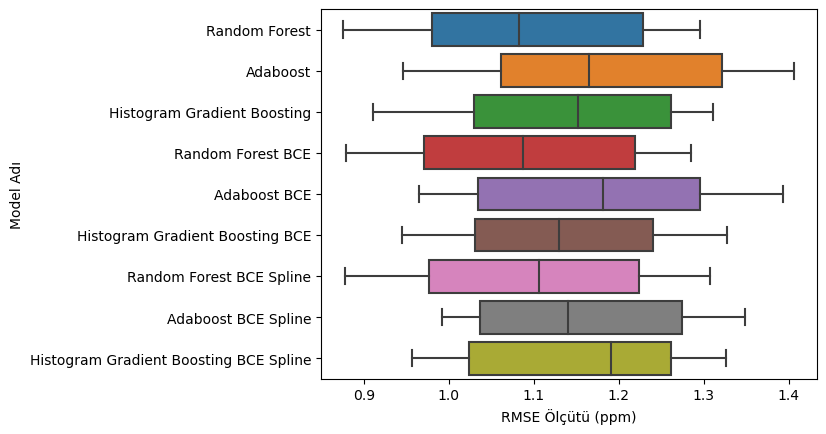

,Random Forest,Adaboost,Histogram Gradient Boosting,Random Forest BCE,Adaboost BCE,Histogram Gradient Boosting BCE,Random Forest BCE Spline,Adaboost BCE Spline,Histogram Gradient Boosting BCE Spline
Split_0_Test_Score,1.295506,1.397139,1.275694,1.276787,1.335836,1.283303,1.276123,1.348378,1.307766
Split_1_Test_Score,0.875714,0.945620,0.910241,0.879314,0.965012,0.944286,0.877597,0.992800,0.956753
Split_2_Test_Score,0.927301,1.023801,1.018227,0.918406,0.996037,1.003011,0.917690,0.992385,0.972748
Split_3_Test_Score,1.032007,1.098136,1.040952,1.021877,1.072201,1.058829,1.035649,1.079740,1.074867
Split_4_Test_Score,1.162219,1.244895,1.247415,1.161861,1.254547,1.198042,1.171263,1.214141,1.215470
Split_5_Test_Score,1.293400,1.406357,1.310799,1.284867,1.393420,1.326934,1.307415,1.333247,1.326282
Split_6_Test_Score,1.082140,1.164679,1.151816,1.087294,1.180873,1.129651,1.105856,1.140296,1.190797
Mean,1.095470,1.182947,1.136449,1.090058,1.171132,1.134865,1.098799,1.157284,1.149241
Std,0.153262,0.164232,0.139695,0.149527,0.154237,0.132250,0.153987,0.136936,0.139550


In [36]:
model_list = {
    "Random Forest": rfMSE,
    "Adaboost": adaboostMSE,
    "Histogram Gradient Boosting": histgradMSE,
    "Random Forest BCE": featureEngRF_CO,
    "Adaboost BCE": featureEngAdaboost_CO,
    "Histogram Gradient Boosting BCE": featureEngHistGrad_CO,
    "Random Forest BCE Spline": splineRF_CO,
    "Adaboost BCE Spline": splineAdaboost_CO,
    "Histogram Gradient Boosting BCE Spline": splineHistGrad_CO
}

cv_results_efficiency = evaluator(model_list, fold_of_cv)

In [37]:
p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random Forest BCE Spline"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random Forest"], alternative="less")
display("Spline used results are {} than original dataset for Random Forest. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost BCE Spline"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost"], alternative="less")
display("Spline used results are {} than original dataset for Adaboost. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Histogram Gradient Boosting BCE Spline"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Histogram Gradient Boosting"], alternative="less")
display("Spline used results are {} than original dataset for Hist Grad. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Spline used results are NOT better than original dataset for Random Forest. P-value is 0.503'

'Spline used results are NOT better than original dataset for Adaboost. P-value is 0.387'

'Spline used results are NOT better than original dataset for Hist Grad. P-value is 0.505'

# Feature Selection

In [17]:
best_model = featureEngRF_CO.best_estimator_.steps[1][1]
transformer = efficiency_feature(0.32)

In [17]:

transformer = efficiency_feature(0.32)
importance_analysis_CO = permutation_importance(best_model, transformer.fit_transform(X_train), y_train, n_repeats=n_iter, n_jobs=1, scoring="neg_mean_squared_error", random_state=random_state)

%store importance_analysis_CO

Stored 'importance_analysis_CO' (Bunch)


,Feature_name,Feature_importance_mean,Feature_importance_std
2,AP,0.210705,0.009855
1,AH,0.280194,0.008293
9,BCE,0.291816,0.008216
3,AT,0.345951,0.009058
0,AFDP,0.698277,0.019343
5,GTEP,1.033748,0.015209
4,CDP,1.969565,0.025644
7,TEY,3.585084,0.065205
6,TAT,6.735021,0.117299
8,TIT,9.563199,0.134679


Text(0.5, 0, 'Nitelik Önemi')

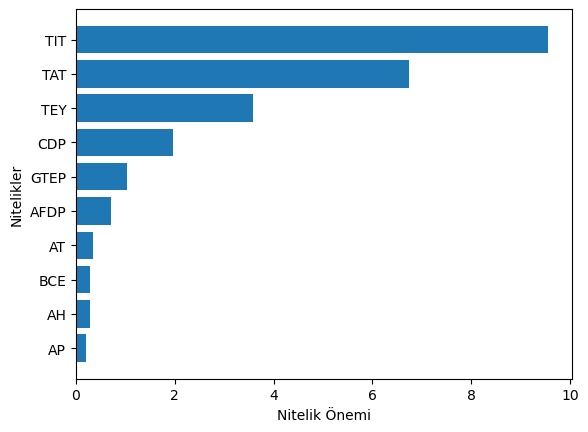

In [40]:
importance_analysis_df = pd.DataFrame(
    {
        "Feature_name": transformer.fit_transform(X_train).columns,
        "Feature_importance_mean": importance_analysis_CO.importances_mean,
        "Feature_importance_std": importance_analysis_CO.importances_std
    }
).sort_values(by="Feature_importance_mean")
display(importance_analysis_df)

fig, ax = plt.subplots()
ax.barh(y=importance_analysis_df.Feature_name, width=importance_analysis_df.Feature_importance_mean)
ax.set_ylabel("Nitelikler")
ax.set_xlabel("Nitelik Önemi")

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  4.7min finished


Text(0.5, 0.98, '')

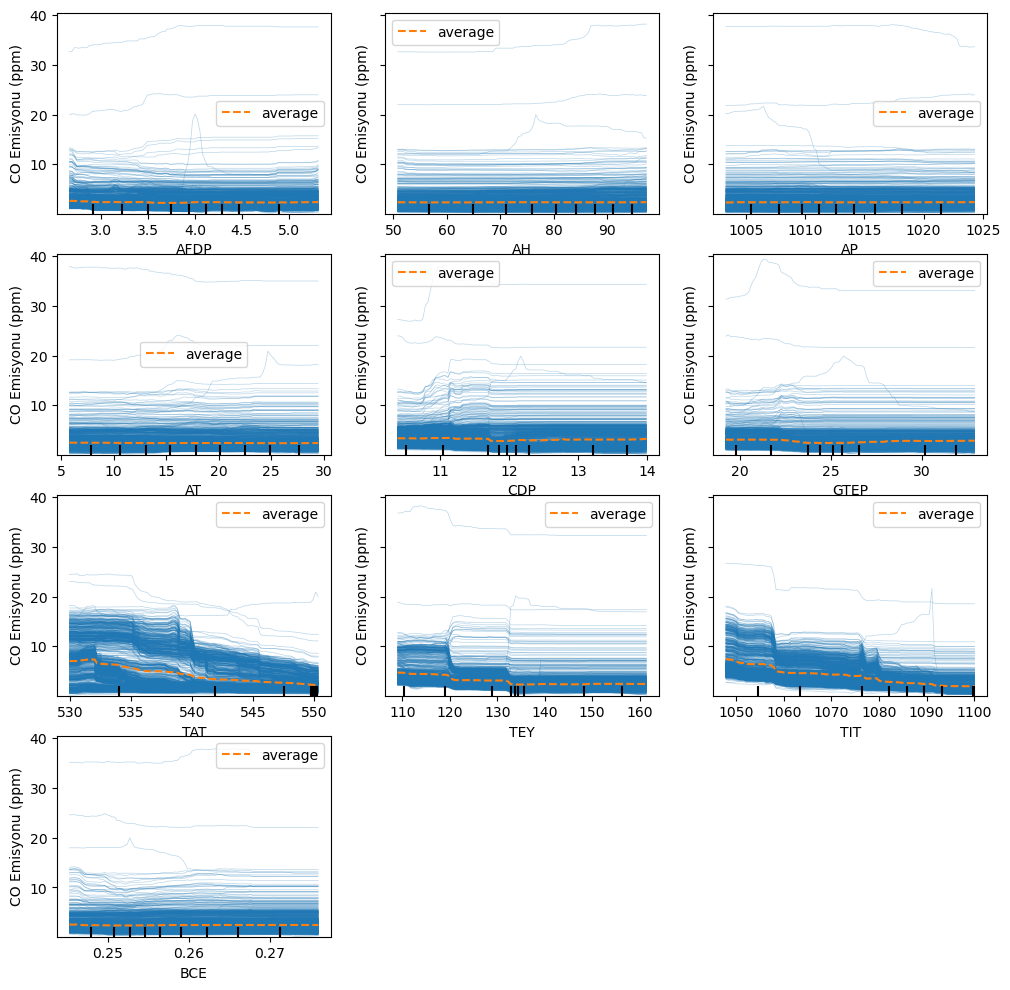

In [18]:
fig, ax = plt.subplots()
plotter = PartialDependenceDisplay.from_estimator(best_model, transformer.fit_transform(X_train), [i for i in range(len(transformer.fit_transform(X_train).columns))], n_jobs=2, verbose=3, ax=ax, kind="both", random_state=random_state)

for ax, feature in zip(plotter.axes_.ravel(), transformer.fit_transform(X_train).columns):
    ax.set_xlabel(feature)
    ax.set_ylabel("CO Emisyonu (ppm)")

fig.set_size_inches(12, 12)
fig.suptitle("")

In [ ]:
filterRF_CO, filterAdaboost_CO, filterHistGrad_CO = model_random_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_filter=True, filter_columns=["AP"], use_spline=True, use_efficiency=True, polytropic_compression=0.32)

%store filterRF_CO
%store filterAdaboost_CO
%store filterHistGrad_CO

100%|██████████| 12/12 [00:03<00:00,  3.16it/s]


Test Results:
Random_Forest için elde edilen R^2 değeri: 0.7828
Random_Forest için elde edilen RMSE değeri: 1.0174

**************************************************

Test Results:
Adaboost için elde edilen R^2 değeri: 0.7221
Adaboost için elde edilen RMSE değeri: 1.1509

**************************************************

Test Results:
Hist_Grad için elde edilen R^2 değeri: 0.7450
Hist_Grad için elde edilen RMSE değeri: 1.1024

**************************************************

Test Results:
Random_Forest_Feature_Eng için elde edilen R^2 değeri: 0.7845
Random_Forest_Feature_Eng için elde edilen RMSE değeri: 1.0136

**************************************************

Test Results:
Adaboost_Feature_Eng için elde edilen R^2 değeri: 0.7407
Adaboost_Feature_Eng için elde edilen RMSE değeri: 1.1117

**************************************************

Test Results:
Hist_Grad_Feature_Eng için elde edilen R^2 değeri: 0.7587
Hist_Grad_Feature_Eng için elde edilen RMSE değeri: 1.0724

********

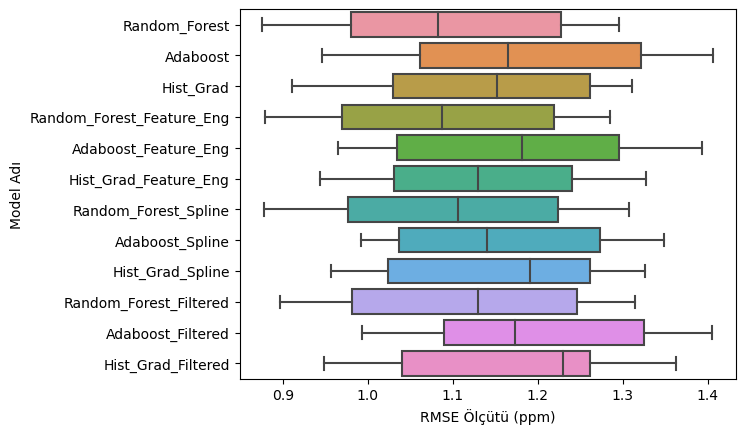

,Random_Forest,Adaboost,Hist_Grad,Random_Forest_Feature_Eng,Adaboost_Feature_Eng,Hist_Grad_Feature_Eng,Random_Forest_Spline,Adaboost_Spline,Hist_Grad_Spline,Random_Forest_Filtered,Adaboost_Filtered,Hist_Grad_Filtered
Split_0_Test_Score,1.295506,1.397139,1.275694,1.276787,1.335836,1.283303,1.276123,1.348378,1.307766,1.290126,1.405129,1.362551
Split_1_Test_Score,0.875714,0.945620,0.910241,0.879314,0.965012,0.944286,0.877597,0.992800,0.956753,0.896323,1.092811,0.948026
Split_2_Test_Score,0.927301,1.023801,1.018227,0.918406,0.996037,1.003011,0.917690,0.992385,0.972748,0.921068,0.993583,0.975909
Split_3_Test_Score,1.032007,1.098136,1.040952,1.021877,1.072201,1.058829,1.035649,1.079740,1.074867,1.041101,1.086674,1.103706
Split_4_Test_Score,1.162219,1.244895,1.247415,1.161861,1.254547,1.198042,1.171263,1.214141,1.215470,1.202286,1.273021,1.237233
Split_5_Test_Score,1.293400,1.406357,1.310799,1.284867,1.393420,1.326934,1.307415,1.333247,1.326282,1.313906,1.376961,1.286600
Split_6_Test_Score,1.082140,1.164679,1.151816,1.087294,1.180873,1.129651,1.105856,1.140296,1.190797,1.129866,1.173072,1.229352
Mean,1.095470,1.182947,1.136449,1.090058,1.171132,1.134865,1.098799,1.157284,1.149241,1.113525,1.200179,1.163340
Std,0.153262,0.164232,0.139695,0.149527,0.154237,0.132250,0.153987,0.136936,0.139550,0.155356,0.144613,0.146259


In [41]:
model_list = {
    "Random_Forest": rfMSE,
    "Adaboost": adaboostMSE,
    "Hist_Grad": histgradMSE,
    "Random_Forest_Feature_Eng": featureEngRF_CO,
    "Adaboost_Feature_Eng": featureEngAdaboost_CO,
    "Hist_Grad_Feature_Eng": featureEngHistGrad_CO,
    "Random_Forest_Spline": splineRF_CO,
    "Adaboost_Spline": splineAdaboost_CO,
    "Hist_Grad_Spline": splineHistGrad_CO,
    "Random_Forest_Filtered": filterRF_CO,
    "Adaboost_Filtered": filterAdaboost_CO,
    "Hist_Grad_Filtered": filterHistGrad_CO
}

cv_results_efficiency = evaluator(model_list, fold_of_cv)

In [42]:
p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random_Forest_Filtered"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random_Forest"], alternative="less")
display("Spline used results are {} than original dataset for Random Forest. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost_Filtered"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost"], alternative="less")
display("Spline used results are {} than original dataset for Adaboost. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Hist_Grad_Filtered"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Hist_Grad"], alternative="less")
display("Spline used results are {} than original dataset for Hist Grad. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Spline used results are NOT better than original dataset for Random Forest. P-value is 0.493'

'Spline used results are NOT better than original dataset for Adaboost. P-value is 0.510'

'Spline used results are NOT better than original dataset for Hist Grad. P-value is 0.504'

# Bayesian Search CV

In [24]:
def model_bayes_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_spline=False, use_efficiency=False, use_filter=False, polytropic_compression=0.28, filter_columns=None, metric="neg_mean_squared_error"):
     # Histogram Gradient Random Search
    random_forest_pipeline = Pipeline(steps=[
        ("random_forest", RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state=random_state))
    ])

    if use_spline:
        random_forest_pipeline.steps.insert(0, ("spline", SplineTransformer()))

    if use_filter:
        random_forest_pipeline.steps.insert(0, ("filter", feature_filter(filter_columns)))

    if use_efficiency:
        random_forest_pipeline.steps.insert(0, ("eff_addition", efficiency_feature(polytropic_compression)))

    param_distributions = {
        "random_forest__n_estimators": Integer(5, 350),
        "random_forest__max_depth": Integer(5, 50),
        "random_forest__max_features": Real(0.1, 1),
        "random_forest__min_samples_leaf": Integer(1, 20)
    }

    bayes_search_random_forest = BayesSearchCV(random_forest_pipeline, search_spaces=param_distributions, scoring=metric, cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
    bayes_search_random_forest.fit(X_train, y_train)
    display("Histogram Gradient end.")
    return bayes_search_random_forest


In [ ]:
bayes_search_random_forest_CO = model_bayes_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_efficiency=True, use_spline=True, polytropic_compression=0.32)

%store bayes_search_random_forest_CO

100%|██████████| 13/13 [00:04<00:00,  3.15it/s]

Test Results:
Random_Forest için elde edilen R^2 değeri: 0.7828
Random_Forest için elde edilen RMSE değeri: 1.0174

**************************************************

Test Results:
Adaboost için elde edilen R^2 değeri: 0.7221
Adaboost için elde edilen RMSE değeri: 1.1509

**************************************************

Test Results:
Hist_Grad için elde edilen R^2 değeri: 0.7450
Hist_Grad için elde edilen RMSE değeri: 1.1024

**************************************************

Test Results:
Random_Forest_Spline için elde edilen R^2 değeri: 0.7883
Random_Forest_Spline için elde edilen RMSE değeri: 1.0045

**************************************************

Test Results:
Adaboost_Spline için elde edilen R^2 değeri: 0.7515
Adaboost_Spline için elde edilen RMSE değeri: 1.0882

**************************************************

Test Results:
Hist_Grad_Spline için elde edilen R^2 değeri: 0.7507
Hist_Grad_Spline için elde edilen RMSE değeri: 1.0900

**************************************

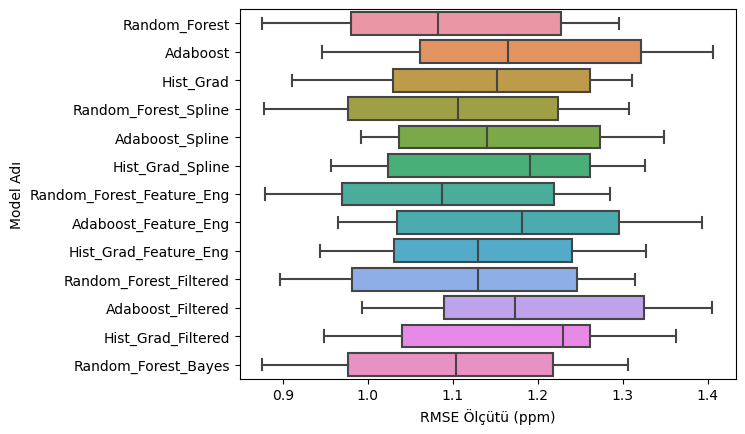

,Random_Forest,Adaboost,Hist_Grad,Random_Forest_Spline,Adaboost_Spline,Hist_Grad_Spline,Random_Forest_Feature_Eng,Adaboost_Feature_Eng,Hist_Grad_Feature_Eng,Random_Forest_Filtered,Adaboost_Filtered,Hist_Grad_Filtered,Random_Forest_Bayes
Split_0_Test_Score,1.295506,1.397139,1.275694,1.276123,1.348378,1.307766,1.276787,1.335836,1.283303,1.290126,1.405129,1.362551,1.276588
Split_1_Test_Score,0.875714,0.945620,0.910241,0.877597,0.992800,0.956753,0.879314,0.965012,0.944286,0.896323,1.092811,0.948026,0.875963
Split_2_Test_Score,0.927301,1.023801,1.018227,0.917690,0.992385,0.972748,0.918406,0.996037,1.003011,0.921068,0.993583,0.975909,0.914901
Split_3_Test_Score,1.032007,1.098136,1.040952,1.035649,1.079740,1.074867,1.021877,1.072201,1.058829,1.041101,1.086674,1.103706,1.038744
Split_4_Test_Score,1.162219,1.244895,1.247415,1.171263,1.214141,1.215470,1.161861,1.254547,1.198042,1.202286,1.273021,1.237233,1.159315
Split_5_Test_Score,1.293400,1.406357,1.310799,1.307415,1.333247,1.326282,1.284867,1.393420,1.326934,1.313906,1.376961,1.286600,1.306714
Split_6_Test_Score,1.082140,1.164679,1.151816,1.105856,1.140296,1.190797,1.087294,1.180873,1.129651,1.129866,1.173072,1.229352,1.103813
Mean,1.095470,1.182947,1.136449,1.098799,1.157284,1.149241,1.090058,1.171132,1.134865,1.113525,1.200179,1.163340,1.096577
Std,0.153262,0.164232,0.139695,0.153987,0.136936,0.139550,0.149527,0.154237,0.132250,0.155356,0.144613,0.146259,0.153796


In [26]:
model_list = {
    "Random_Forest": rfMSE,
    "Adaboost": adaboostMSE,
    "Hist_Grad": histgradMSE,
    "Random_Forest_Spline": splineRF_CO,
    "Adaboost_Spline": splineAdaboost_CO,
    "Hist_Grad_Spline": splineHistGrad_CO,
    "Random_Forest_Feature_Eng": featureEngRF_CO,
    "Adaboost_Feature_Eng": featureEngAdaboost_CO,
    "Hist_Grad_Feature_Eng": featureEngHistGrad_CO,
    "Random_Forest_Filtered": filterRF_CO,
    "Adaboost_Filtered": filterAdaboost_CO,
    "Hist_Grad_Filtered": filterHistGrad_CO,
    "Random_Forest_Bayes": bayes_search_random_forest_CO
}

cv_results_efficiency = evaluator(model_list, fold_of_cv)

# Model Results

In [24]:
splineRF_CO.best_params_

{'random_forest__n_estimators': 235,
 'random_forest__min_samples_leaf': 1,
 'random_forest__max_features': 0.1,
 'random_forest__max_depth': 50}

,True_values,Predicted_values,Residuals
count,11020.000000,11020.000000,11020.000000
mean,2.368544,2.401039,-0.032495
std,2.183227,1.984984,1.003999
min,0.005033,0.253792,-19.007899
25%,1.188125,1.311419,-0.340789
50%,1.714850,1.709654,-0.058662
75%,2.835750,2.746182,0.221853
max,37.746000,29.483324,34.534655


1.0044788247417984

,True_values,Predicted_values,Residuals
6969,4.77510,5.529746,-0.754646
5692,3.41710,3.001495,0.415605
4571,0.22379,0.670880,-0.447090
4943,1.43630,1.324531,0.111769
3791,0.67721,1.278799,-0.601589
1362,1.61940,1.285396,0.334004
3871,4.61430,4.392343,0.221957
3612,0.30225,1.085215,-0.782965
3639,5.63660,2.730318,2.906282
4651,2.20450,2.253454,-0.048954


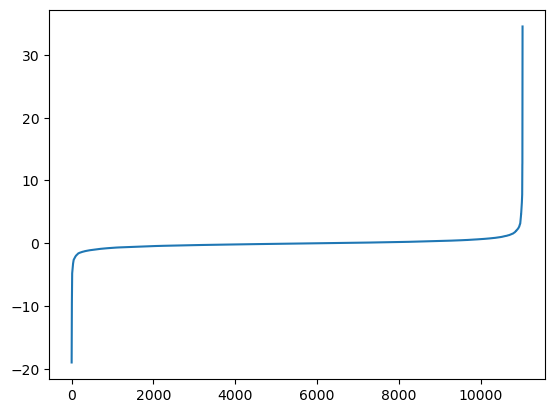

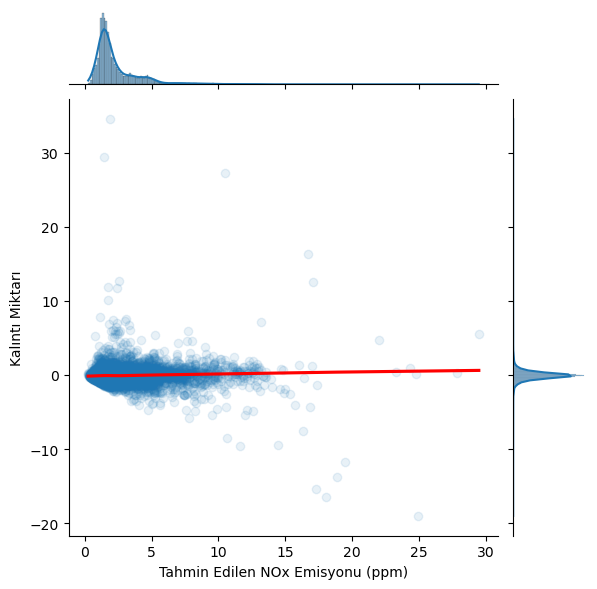

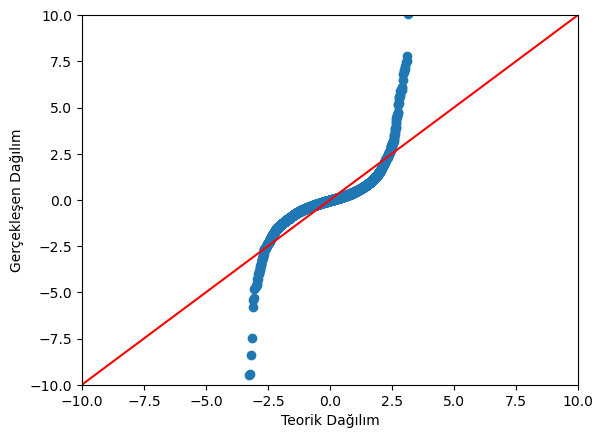

In [17]:
best_model = splineRF_CO.best_estimator_
results_df = pd.DataFrame({
    "True_values": y_test,
    "Predicted_values": best_model.predict(X_test),
})

results_df = results_df.assign(
    Residuals=(results_df.True_values.values - results_df.Predicted_values.values)
    )

display(results_df.describe())
display(np.sqrt(MSE(results_df.True_values, results_df.Predicted_values)))
#display(results_df.sort_values(by="Residuals").tail(20))
display(results_df.sample(50))

sns.lineplot(x=range(len(results_df)), y=results_df.sort_values(by="Residuals").Residuals.values)
plt.show()

grid = sns.jointplot(data=results_df, x="Predicted_values", y="Residuals", kind="reg", joint_kws={"lowess":True, "line_kws":{"color": "red"}, "scatter_kws":{"alpha": 0.1}})
grid.set_axis_labels("Tahmin Edilen NOx Emisyonu (ppm)", "Kalıntı Miktarı")
plt.show()

ax = sm.qqplot(results_df.Residuals, line="45", fit=True)
ax.axes[0].set_xlim(-10, 10)
ax.axes[0].set_ylim(-10, 10)
ax.axes[0].set_xlabel("Teorik Dağılım")
ax.axes[0].set_ylabel("Gerçekleşen Dağılım")
plt.show()

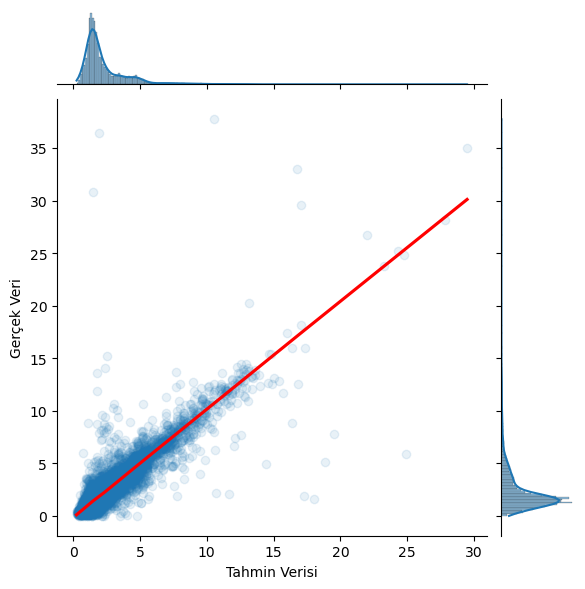

In [18]:
grid = sns.jointplot(data=results_df, x="Predicted_values", y="True_values", kind="reg", joint_kws={"lowess":True, "line_kws":{"color": "red"}, "scatter_kws":{"alpha": 0.1}})
grid.set_axis_labels("Tahmin Verisi", "Gerçek Veri")
plt.show()